In [2]:
# Cargo las librerías necesarias
from sklearn.metrics import confusion_matrix
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt
from os import scandir, getcwd
from os.path import abspath
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import pickle
from joblib import dump, load

# Seteo de paths y archivos de prueba
PATH_POSITIVE_TRAIN = "data/train/pedestrians/"
PATH_NEGATIVE_TRAIN = "data/train/background/"
PATH_POSITIVE_TEST = "data/test/pedestrians/"
PATH_NEGATIVE_TEST = "data/test/background/"
EXAMPLE_POSITIVE = PATH_POSITIVE_TEST + "AnnotationsPos_0.000000_crop_000011b_0.png"
EXAMPLE_NEGATIVE = PATH_NEGATIVE_TEST + "AnnotationsNeg_0.000000_00000002a_0.png"

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Función para graficar una matriz de confusion
    
    Parámetros:
    cm --      matriz de confusion
    classes -- etiquetas de las clases
    title --   título del grafico
    cmap --    colores a emplear para graficar
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Seccion 1. Prueba sobre el dataset de test

Cargo los datos de entrenammiento

In [2]:
X_train_HOG = np.load("X_Train_HOG.npy") # HOG
X_train_LBP = np.load("X_Train_lbp.npy") # LBP
y_train = np.load("y_train_lbp.npy")     # Etiquetas
X_train_mix = np.concatenate((X_train_HOG, X_train_LBP), axis = 1) # Uno HOG + LBP

In [3]:
# Creo una SVM con kernel linear
clf = SVC(kernel="linear")

# Entreno la SVM
clf.fit(X_train_mix, y_train)

# Guardo el modelo entreando
dump(clf, 'HOG+LBP_clf.joblib')


['HOG+LBP_clf.joblib']

Cargo los datos de test

In [4]:
X_test_HOG = np.load("X_Test_HOG.npy")
X_test_LBP = np.load("X_Test_lbp.npy")
X_test_mix = np.concatenate((X_test_HOG, X_test_LBP), axis = 1)
y_test = np.load("y_test_HOG.npy")

In [5]:
# Realizo predicciones sobre el dataset de test
predicciones = clf.predict(X_test_mix)

# Imprimo un reporte de la clasificación
target_names = ['background', 'pedestrians']
print(classification_report(y_test, predicciones, target_names=target_names))

              precision    recall  f1-score   support

  background       0.99      1.00      0.99       600
 pedestrians       1.00      0.99      0.99       500

   micro avg       0.99      0.99      0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100



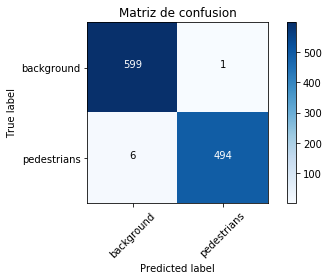

In [6]:
# Calculo la matriz de confusion
cnf_matrix = confusion_matrix(y_test, predicciones)

# Grafico la matriz de confusion
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Matriz de confusion')
plt.savefig("img/HOG_LBP_Confusion.png")

# Seccion 2. K-Fold Cross Validation

In [3]:
data_LBP = np.load("allData_lbp.npy")
data_HOG = np.load("allData_HOG.npy")
allClasses = np.load("allClasses_HOG.npy")

data_merged = np.concatenate((data_HOG, data_LBP), axis = 1)

In [4]:
# Ahora implemento 10 Fold Cross Validation
scores = cross_val_score(SVC(kernel="linear"), data_merged, allClasses, cv=10, n_jobs = 1)
# Con esto puede calcular la exactitud promedio y la varianza
print("Exactitud Promedio (Varianza): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

np.set_printoptions(precision=4)
print("Exactitud de cada fold= {}".format(scores))


Exactitud Promedio (Varianza): 0.9950 (+/- 0.0055)
Exactitud de cada fold= [0.9963 0.9945 0.9945 0.9945 0.9982 0.9945 1.     0.9907 0.9907 0.9963]
